# install librarys

In [1]:
# นำเข้าคลังที่จำเป็น
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# ตัวอย่าง: การใช้ metric เบื้องต้น
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

In [ ]:
data = pd.read_excel('NVDA.xlsx')
data = data[["Close"]].dropna()

# จัดเรียงข้อมูลและ Normalize
scaler = MinMaxScaler()
data["Close_scaled"] = scaler.fit_transform(data[["Close"]])
data = data["Close_scaled"]


In [3]:
# แบ่งข้อมูล train/test
split_point = int(len(data) * 0.8)
train = data.iloc[:split_point]
test = data.iloc[split_point:]

# พัฒนาโมดูลตรวจจับ Drift (Drift Detection Module)

In [53]:
def kl_divergence_drift(data, window=100, bins=30, smoothing_window=5, sensitivity=2):

    kl_values = []
    for i in range(window, len(data) - window):
        p, _ = np.histogram(data[i-window:i], bins=bins, density=True)
        q, _ = np.histogram(data[i:i+window], bins=bins, density=True)
        p = p + 1e-10  # avoid zeros
        q = q + 1e-10
        p /= p.sum()
        q /= q.sum()
        kl = entropy(p, q)
        kl_values.append(kl)
    kl_values = np.array(kl_values)
    
    # Smoothing KL divergence to reduce noise
    kl_values_smooth = np.convolve(kl_values, np.ones(smoothing_window)/smoothing_window, mode='same')
    
    # Dynamic threshold
    threshold = kl_values_smooth.mean() + sensitivity * kl_values_smooth.std()
    
    drift_points = np.where(kl_values_smooth > threshold)[0] + window
    
    return drift_points, kl_values_smooth, threshold


# KL divergence 

KL Divergence Drift Points: [ 282  283  284  285  286  287  288  289  290  291  292  293  294  295
  296  297  298  299  300  301  386  387  388  389  390  391  392  393
  394  395  396  723  724  725  726  727  728  729  730  731  732  746
  747  748  749  750  751  752  753  962  963  964  965  966  967  968
 1459 1460 1461 1462 1582 1583 1584 1585 1586 1587 1588 1589 1590 1591
 1592 1593 1594 1595 1596 1597 2024 2025 2026 2027 2028 2029 2030 2031
 2032 2033 2034 2049 2050 2051 2052 2053 2054 2055 2056 2057 2058 2059
 2060 2175 2176 2177 2178 2179 2180 2181 2182 2183 2184 2185]


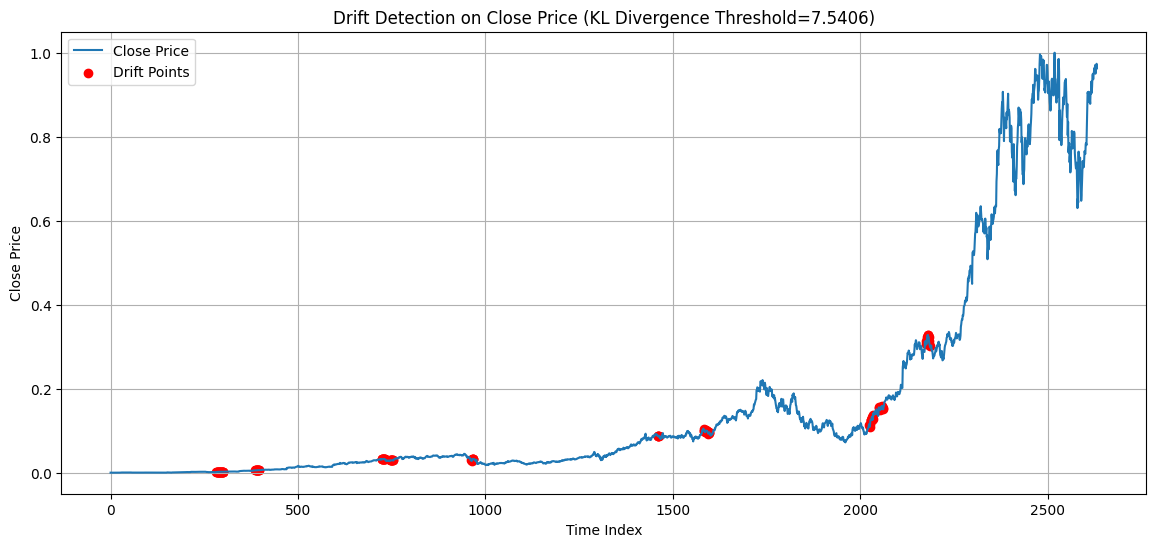

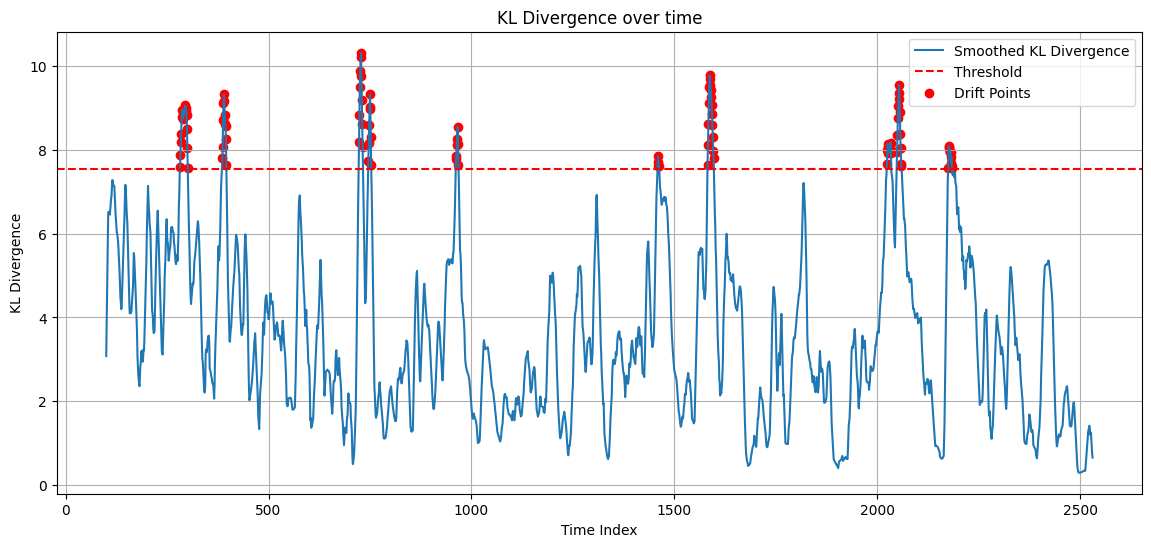

In [59]:
    # ตัวอย่างสร้างข้อมูลจำลอง
if __name__ == "__main__":

    #data1 = pd.DataFrame({'Close': np.concatenate([train.values, test.values])})
  
    close_prices = data.values
    
    # 1. Detect drift ด้วย KL divergence
    drift_points, kl_values_smooth, kl_threshold = kl_divergence_drift(close_prices, window=100, bins=30, smoothing_window=10, sensitivity=2)
    print(f"KL Divergence Drift Points: {drift_points}")
    
    plt.figure(figsize=(14,6))
    plt.plot(close_prices, label='Close Price')
    plt.scatter(drift_points, close_prices[drift_points], color='red', label='Drift Points')
    plt.title(f'Drift Detection on Close Price (KL Divergence Threshold={kl_threshold:.4f})')
    plt.xlabel('Time Index')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(14,6))
    plt.plot(range(100, 100 + len(kl_values_smooth)), kl_values_smooth, label='Smoothed KL Divergence')
    plt.axhline(kl_threshold, color='red', linestyle='--', label='Threshold')
    plt.scatter(drift_points, kl_values_smooth[drift_points - 100], color='red', label='Drift Points')
    plt.title('KL Divergence over time')
    plt.xlabel('Time Index')
    plt.ylabel('KL Divergence')
    plt.legend()
    plt.grid(True)
    plt.show()


# CUSUM

CUSUM Drift detected at indices: [  3   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38
  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74
  76  78  80  82  84  86  88  90  92  94  96  98 100 102 104 106 108 110
 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144 146
 148 150 152 154 156 158 160 162 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 3

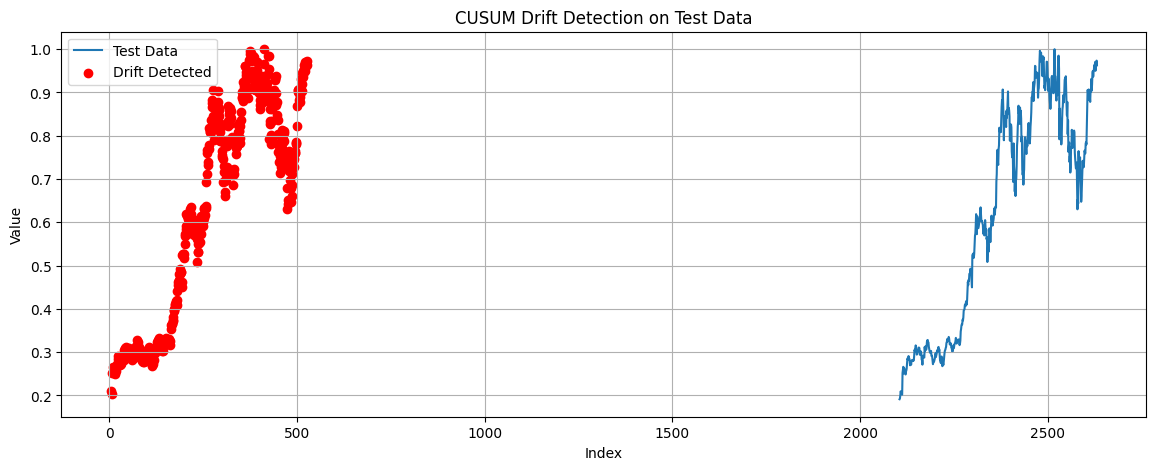

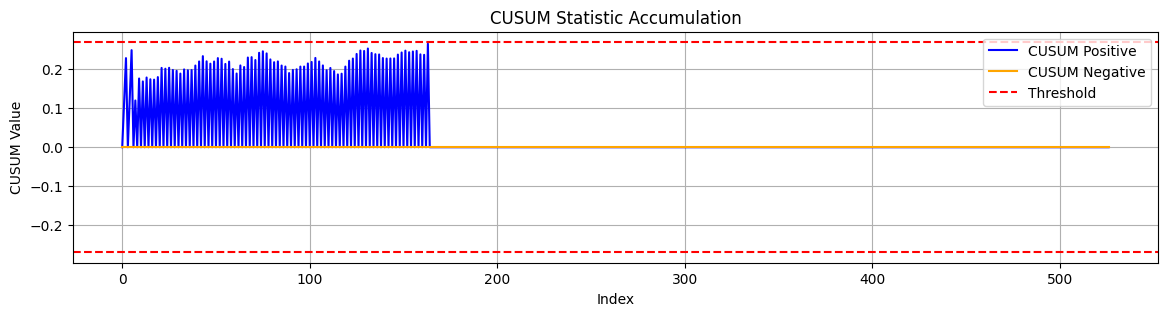

In [61]:
def run_cusum(data, mu, k, h):
    s_pos = np.zeros_like(data)
    s_neg = np.zeros_like(data)
    drift_indices = []

    for i in range(1, len(data)):
        s_pos[i] = max(0, s_pos[i-1] + data[i] - mu - k)
        s_neg[i] = min(0, s_neg[i-1] + data[i] - mu + k)
        if s_pos[i] > h:
            drift_indices.append(i)
            s_pos[i] = 0  # reset after drift detected
        if s_neg[i] < -h:
            drift_indices.append(i)
            s_neg[i] = 0  # reset after drift detected

    return s_pos, s_neg, np.array(drift_indices)

# 2. คำนวณ baseline ค่า mean และ std จาก train data
mu = np.mean(train)
sigma = np.std(train)

# 3. กำหนดพารามิเตอร์ CUSUM
k = 0.5 * sigma
h = 5 * sigma

# 4. เรียกใช้ CUSUM กับ test data
s_pos, s_neg, drift_indices = run_cusum(test.to_numpy(), mu, k, h)
print(f"CUSUM Drift detected at indices: {drift_indices}")

plt.figure(figsize=(14,5))
plt.plot(test, label='Test Data')
if len(drift_indices) > 0:
    plt.scatter(drift_indices, test.iloc[drift_indices], color='red', label='Drift Detected')  # <-- แก้ตรงนี้
plt.title('CUSUM Drift Detection on Test Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,3))
plt.plot(s_pos, label='CUSUM Positive', color='blue')
plt.plot(s_neg, label='CUSUM Negative', color='orange')
plt.axhline(h, color='red', linestyle='--', label='Threshold')
plt.axhline(-h, color='red', linestyle='--')
plt.title('CUSUM Statistic Accumulation')
plt.xlabel('Index')
plt.ylabel('CUSUM Value')
plt.legend()
plt.grid(True)
plt.show()

# ออกแบบ Adative Cross - Validation Splits

In [ ]:
def adaptive_cv_splits(data, drift_points, min_train_size=50, test_size=30):
    splits = []
    drift_points = [0] + sorted(drift_points) + [len(data)]
    for i in range(1, len(drift_points)-1):
        train_start = drift_points[i-1]
        train_end = drift_points[i]
        test_start = drift_points[i]
        test_end = min(test_start + test_size, drift_points[i+1])

        if train_end - train_start >= min_train_size and test_end > test_start:
            train_idx = np.arange(train_start, train_end)
            test_idx = np.arange(test_start, test_end)
            splits.append((train_idx, test_idx))
    return splits

def rolling_window_cv_splits(data, window_size=100, test_size=30, step=30):
    splits = []
    n = len(data)
    for start in range(0, n - window_size - test_size + 1, step):
        train_idx = np.arange(start, start + window_size)
        test_idx = np.arange(start + window_size, start + window_size + test_size)
        splits.append((train_idx, test_idx))
    return splits


In [ ]:
drift_points = [300,301,386]
splits = adaptive_cv_splits(data, drift_points, min_train_size=50, test_size=30)

for i, (train_idx, test_idx) in enumerate(splits):
    print(f"Fold {i+1}: Train({len(train_idx)}) Test({len(test_idx)})")


Fold 1: Train(300) Test(30)
Fold 2: Train(85) Test(30)


In [38]:
# ---- 1. สร้าง splits ทั้งสองแบบ ----
adaptive_splits = adaptive_cv_splits(data, drift_points, min_train_size=50, test_size=30)
rolling_splits = rolling_window_cv_splits(data, window_size=100, test_size=30, step=30)

# ---- 2. เปรียบเทียบจำนวน fold ----
print(f"Adaptive CV Folds: {len(adaptive_splits)}")
print(f"Rolling Window Folds: {len(rolling_splits)}")


Adaptive CV Folds: 2
Rolling Window Folds: 84


[(range(0, 300), range(300, 330)), (range(301, 386), range(386, 416))]


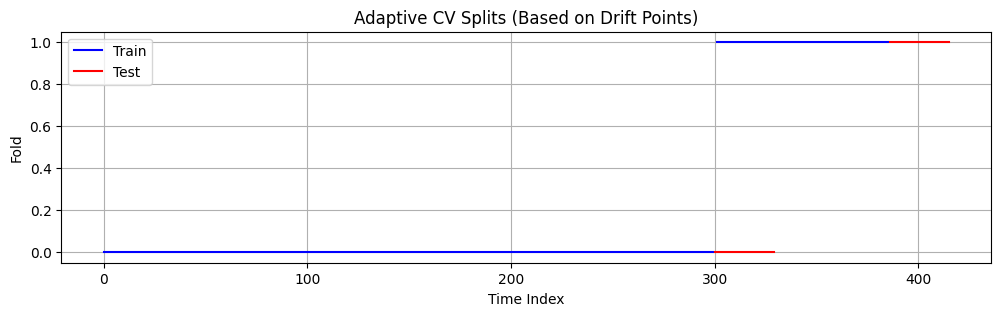

[(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129])), (array([ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  9

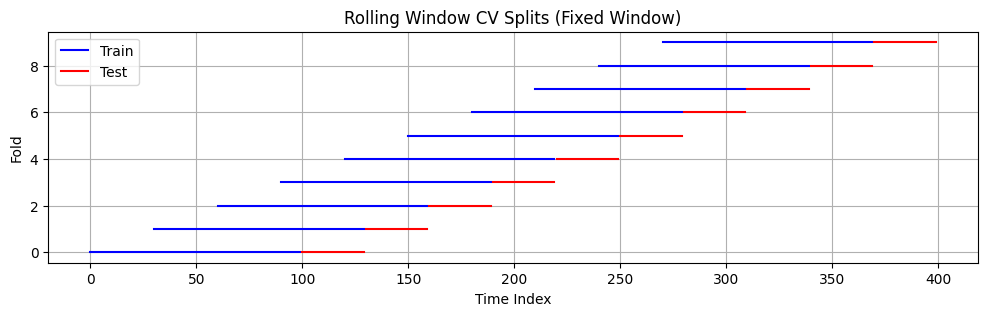

In [39]:
def plot_cv_splits(splits, title):
    plt.figure(figsize=(12, 3))
    for i, (train_idx, test_idx) in enumerate(splits[:10]):
        plt.plot(train_idx, [i]*len(train_idx), color='blue', label='Train' if i == 0 else "")
        plt.plot(test_idx, [i]*len(test_idx), color='red', label='Test' if i == 0 else "")
    plt.title(title)
    plt.xlabel("Time Index")
    plt.ylabel("Fold")
    plt.legend()
    plt.grid(True)
    plt.show()

print(adaptive_splits)
plot_cv_splits(adaptive_splits, "Adaptive CV Splits (Based on Drift Points)")
print(rolling_splits)
plot_cv_splits(rolling_splits, "Rolling Window CV Splits (Fixed Window)")


# Model Traning & Evaluation

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mean_coverage_width(y_true, y_lower, y_upper):
    coverage = ((y_true >= y_lower) & (y_true <= y_upper)).mean()
    width = (y_upper - y_lower).mean()
    return coverage, width

def rolling_cv_splits(data, window_size=100, test_size=30, step=30):
    splits = []
    for start in range(0, len(data) - window_size - test_size + 1, step):
        train_idx = range(start, start + window_size)
        test_idx = range(start + window_size, start + window_size + test_size)
        splits.append((train_idx, test_idx))
    return splits

def adaptive_cv_splits(data, drift_points, min_train_size=50, test_size=30):
    splits = []
    drift_points = [0] + sorted(drift_points) + [len(data)]
    for i in range(1, len(drift_points)-1):
        train_start = drift_points[i-1]
        train_end = drift_points[i]
        test_start = drift_points[i]
        test_end = min(test_start + test_size, len(data))
        if train_end - train_start >= min_train_size:
            splits.append((range(train_start, train_end), range(test_start, test_end)))
    return splits

In [47]:
from statsmodels.tsa.arima.model import ARIMA

def train_arima(train_data, test_data, order=(5,1,0)):
    model = ARIMA(train_data, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test_data))
    return forecast


In [48]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

def prepare_lstm_data(series, n_steps):
    X, y = [], []
    for i in range(len(series) - n_steps):
        X.append(series[i:i+n_steps])
        y.append(series[i+n_steps])
    return np.array(X), np.array(y)

def train_lstm(train_data, test_len, n_steps=10, epochs=10):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()

    X, y = prepare_lstm_data(scaled, n_steps)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential([
        LSTM(50, activation='relu', input_shape=(n_steps, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, verbose=0)

    last_seq = scaled[-n_steps:]
    predictions = []
    for _ in range(test_len):
        x_input = last_seq.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)[0][0]
        predictions.append(yhat)
        last_seq = np.append(last_seq[1:], yhat)

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

def evaluate_model(data, splits, model_type='arima'):
    results = []

    for train_idx, test_idx in splits:
        train = data.iloc[train_idx].values
        test = data.iloc[test_idx].values

        if model_type == 'arima':
            preds = train_arima(train, test)
        elif model_type == 'lstm':
            preds = train_lstm(train, len(test))
        else:
            raise ValueError("Unknown model")

        results.append({
            'rmse': rmse(test, preds),
            'mae': mean_absolute_error(test, preds)
        })

    return pd.DataFrame(results)


In [51]:
# กำหนดฟังก์ชัน rolling และ adaptive split ให้เรียบร้อยก่อน
rolling_splits = rolling_cv_splits(data, window_size=100, test_size=30)
adaptive_splits = adaptive_cv_splits(data, drift_points=[300,301,386], test_size=30)

# เลือกคอลัมน์แรกสำหรับ ARIMA (เนื่องจาก ARIMA รองรับแค่ 1 คอลัมน์)
#arima_data = data.iloc[:, 0]

# ประเมินโมเดล ARIMA
arima_rolling = evaluate_model(data, rolling_splits, model_type='arima')
arima_adaptive = evaluate_model(data, adaptive_splits, model_type='arima')

# ประเมินโมเดล LSTM (สามารถใช้ข้อมูลหลายคอลัมน์ได้)
lstm_rolling = evaluate_model(data, rolling_splits, model_type='lstm')
lstm_adaptive = evaluate_model(data, adaptive_splits, model_type='lstm')

# แสดงผล
print("ARIMA (Rolling CV):", arima_rolling)
print("ARIMA (Adaptive CV):", arima_adaptive)
print("LSTM (Rolling CV):", lstm_rolling)
print("LSTM (Adaptive CV):", lstm_adaptive)

C:\Users\praph\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\praph\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\praph\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\praph\AppData\Local\Packages

ARIMA (Rolling CV):         rmse       mae
0   0.000161  0.000118
1   0.000371  0.000260
2   0.000196  0.000162
3   0.000612  0.000552
4   0.000454  0.000424
..       ...       ...
79  0.034604  0.029023
80  0.042367  0.036401
81  0.125602  0.111185
82  0.053302  0.041795
83  0.175687  0.154517

[84 rows x 2 columns]
ARIMA (Adaptive CV):        rmse       mae
0  0.000542  0.000494
1  0.000692  0.000543
LSTM (Rolling CV):         rmse       mae
0   0.000406  0.000313
1   0.000313  0.000209
2   0.000416  0.000376
3   0.000874  0.000819
4   0.001180  0.000875
..       ...       ...
79  0.142009  0.134705
80  0.118590  0.107347
81  0.126679  0.111161
82  0.077363  0.061006
83  0.049996  0.041050

[84 rows x 2 columns]
LSTM (Adaptive CV):        rmse       mae
0  0.000218  0.000176
1  0.003412  0.003299
